In [1]:
import sys
import platform
sys.path.append('./src/')

if platform.system() == "Windows":
    print("Running on windows")

    %cd ./src/datasets
    !cmd /C get_datasets.cmd
    %cd ..
else:
    print("Running on Mac or linux")

    %cd ./src/datasets
    !bash get_datastets.sh
    %cd ..

Running on windows
D:\Deep Learning\Stanford CS231n\assignment1\src\datasets

(deepenv) D:\Deep Learning\Stanford CS231n\assignment1\src\datasets>IF NOT EXIST "cifar-10-batches-py" (
certutil -urlcache -split -f "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" cifar-10-python.tar.gz  
 tar -xzvf cifar-10-python.tar.gz  
 del cifar-10-python.tar.gz 
) 
D:\Deep Learning\Stanford CS231n\assignment1\src


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup for this notebook.

import random
import numpy as np
from src.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set the default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
from IPython.core.ultratb import VerboseTB
VerboseTB._tb_highlight = "bg:#039dfc"

## CIFAR-10 Data Loading and Preprocessing

In [3]:
#Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

X_train = y_train = X_test = y_test = None
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [4]:
# Split the data into train, validation, and test sets. In addition, we will
# create a small development set as a subset of the training set;
# we can use this for development, so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our Validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (10000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


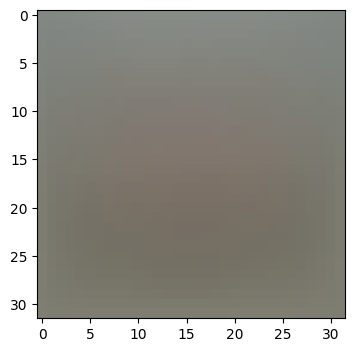

(49000, 3073) (1000, 3073) (10000, 3073) (500, 3073)


In [6]:
# Preprocessing: Mean centering, i.e., subtract the mean image

# First: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[: 10])  # print a few of the elements
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))  # visualize the mean image
plt.show()

# Second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Third: append the bias dimension of ones (i.e., bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix of W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside **`src/classifiers/softmax.py`**.


In [9]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from src.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.324533
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\textcolor{yellow}{\textit Your Answer:}$ *Softmax represents a negative likelihood probability of the correct class. If we assume equally likely, then the likelihood of correct class becomes $-log(\frac{1}{10})$ = -log(0.1)*



In [13]:
# Complete the implementation of softmax_loss_naive and implement a (naive) version
# of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numerical gradient checking as a debugging tool.
# The numerical gradient should be close to the analytic gradient.
from src.gradient_check import  grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_check_sparse(f, W, grad, num_checks=15)

numerical: -0.629961 analytic: -0.629961, relative error: 5.989252e-08
numerical: 0.327567 analytic: 0.327567, relative error: 1.853809e-07
numerical: 0.323795 analytic: 0.323795, relative error: 7.594886e-08
numerical: -1.157208 analytic: -1.157208, relative error: 1.255089e-08
numerical: -0.341750 analytic: -0.341750, relative error: 9.868866e-08
numerical: -0.715988 analytic: -0.715988, relative error: 2.344973e-08
numerical: -2.302511 analytic: -2.302511, relative error: 8.672975e-10
numerical: -3.306498 analytic: -3.306498, relative error: 4.647349e-09
numerical: 2.608698 analytic: 2.608698, relative error: 2.795046e-08
numerical: -0.311179 analytic: -0.311179, relative error: 6.622436e-08
numerical: -2.629440 analytic: -2.629440, relative error: 3.236887e-09
numerical: 1.039237 analytic: 1.039237, relative error: 3.153414e-08
numerical: -1.832006 analytic: -1.832006, relative error: 1.629286e-08
numerical: -0.020232 analytic: -0.020232, relative error: 4.817591e-07
numerical: 2.9

In [14]:
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_check_sparse(f, W, grad, 10)

numerical: -0.638437 analytic: -0.638437, relative error: 3.518771e-08
numerical: 1.657251 analytic: 1.657251, relative error: 8.174295e-09
numerical: 0.377920 analytic: 0.377920, relative error: 2.095596e-08
numerical: 2.164293 analytic: 2.164293, relative error: 4.741710e-09
numerical: -0.730912 analytic: -0.730913, relative error: 4.113376e-08
numerical: 0.763895 analytic: 0.763895, relative error: 6.485724e-08
numerical: 0.086294 analytic: 0.086294, relative error: 7.603680e-07
numerical: -4.627797 analytic: -4.627797, relative error: 1.061601e-08
numerical: -0.826618 analytic: -0.826618, relative error: 1.217491e-08
numerical: 1.612303 analytic: 1.612302, relative error: 2.232974e-08


In [15]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from src.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.324531e+00 computed in 0.309879s
vectorized loss: 2.324531e+00 computed in 0.002995s
Loss difference: 0.000000
Gradient difference: 0.000000


In [16]:
try:
    from tqdm.notebook import tqdm_notebook
except ModuleNotFoundError:
    !pip install tqdm

In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful, you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from src.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifier in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [2.5e-7, 1e-7, 5e-6, 1e-6, 1e-5]
regularization_strengths = [2.5e4, 2e4, 1e4, 8e3, 5e3, 1e3]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in tqdm_notebook(learning_rates, desc="Learning rate"):
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(
            X=X_train, y=y_train, num_iters=1500,
            learning_rate=lr, reg=reg
        )

        y_train_pred = softmax.predict(X=X_train)
        y_val_pred = softmax.predict(X=X_val)

        train_accuracy = np.mean(y_train_pred == y_train)
        val_accuracy = np.mean(y_val_pred == y_val)

        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

Learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.261776 val accuracy: 0.260000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.324939 val accuracy: 0.346000
lr 1.000000e-07 reg 8.000000e+03 train accuracy: 0.348286 val accuracy: 0.360000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.353857 val accuracy: 0.364000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.332735 val accuracy: 0.344000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.333102 val accuracy: 0.349000
lr 2.500000e-07 reg 1.000000e+03 train accuracy: 0.338449 val accuracy: 0.335000
lr 2.500000e-07 reg 5.000000e+03 train accuracy: 0.376122 val accuracy: 0.380000
lr 2.500000e-07 reg 8.000000e+03 train accuracy: 0.361959 val accuracy: 0.371000
lr 2.500000e-07 reg 1.000000e+04 train accuracy: 0.358163 val accuracy: 0.366000
lr 2.500000e-07 reg 2.000000e+04 train accuracy: 0.332286 val accuracy: 0.339000
lr 2.500000e-07 reg 2.500000e+04 train accuracy: 0.333714 val accuracy: 0.354000
lr 1.000000e-06 reg 1.000000

In [23]:
# evaluate on test set
# Evaluate the best softmax on the test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.389000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\textcolor{yellow}{\textit Your Answer:}$</br>
*Yes it's absolutely possible.*

</br>$\textcolor{yellow}{\textit Your Explanation:}$</br>
*SVM loss only cares about whether the margin $(max(0, s_j - s_i + delta)$ is satisfied or not, so if the new data point satisfies this margin the loss for that data-point will be 0. However, Softmax takes summation over all data points $-log(\frac{\exp(s_i)}{\sum_{j=1}^C \exp(s_j)})$, hence the softmax will change.*


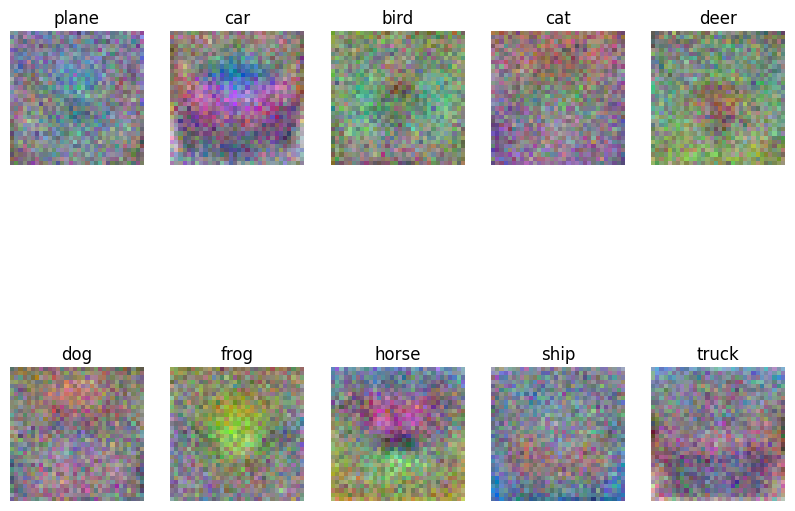

In [24]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1, :]  # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)  # 2 per row

    # Rescale the weights to be between 0 and 255
    w_img = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(w_img.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

plt.show()